<a href="https://colab.research.google.com/github/tth-97/AI-practice/blob/main/batch_normalization_%26_dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
from PIL import Image

In [2]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(device)

cuda


In [6]:
##### AutoEncoder 모델 코드 #####

class Encoder(nn.Module):
    def __init__(self,):
        super(Encoder, self).__init__()
        self.encode = nn.Sequential(nn.Conv2d(3, 6, 5, 1, 0),
                                    nn.BatchNorm2d(6),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2, 2),
                                    nn.Conv2d(6, 16, 5, 1, 0),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2, 2),
        )
    def forward(self, input):
        return self.encode(input)


class Decoder(nn.Module):
    def __init__(self, ):
        super(Decoder, self).__init__()
        self.decode = nn.Sequential(nn.Conv2d(16, 16, 13, 1, 12),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU(),
                                    nn.Conv2d(16, 16, 13, 1, 12),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU(),
                                    nn.Conv2d(16, 6, 13, 1, 12),
                                    nn.BatchNorm2d(6),
                                    nn.ReLU(),
                                    nn.Conv2d(6, 6, 13, 1, 12),
                                    nn.BatchNorm2d(6),
                                    nn.ReLU(),
                                    nn.Conv2d(6, 6, 13, 1, 12),
                                    nn.BatchNorm2d(6),
                                    nn.ReLU(),
                                    nn.Conv2d(6, 3, 19, 1, 18),
                                    nn.BatchNorm2d(3),
                                    nn.Tanh(),
        )
    def forward(self, input):
        return self.decode(input)
        
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, input):
        z = self.encoder(input)
        x_hat = self.decoder(z)
        return z, x_hat

In [5]:
transform = transforms.Compose([transforms.Resize((100, 100)),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.Flowers102(root="StanfordCars/", 
                    split='train', 
                    transform=transform,
                    download=True)
test_dataset = torchvision.datasets.Flowers102(root="StanfordCars/", 
                    split='test',
                    transform=transform,
                    download=True)

100%|██████████| 344862509/344862509 [00:12<00:00, 28028659.25it/s]


Extracting StanfordCars/flowers-102/102flowers.tgz to StanfordCars/flowers-102


100%|██████████| 502/502 [00:00<00:00, 682287.95it/s]


100%|██████████| 14989/14989 [00:00<00:00, 5381188.28it/s]


In [7]:
##### AutoEncoder 학습 코드 #####

batch_size = 255

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

autoencoder = AutoEncoder().to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

epochs = 100
train_avg_costs = []

autoencoder.train()
for epoch in range(epochs):
    autoencoder.train()
    avg_cost = 0
    total_batch_num = len(train_dataloader)
    
    for b_x, b_y in train_dataloader:
        b_x = b_x.to(device)
        z, b_x_hat = autoencoder(b_x) # forward propagation
        loss = criterion(b_x_hat, b_x) # get cost
        
        avg_cost += loss / total_batch_num
        optimizer.zero_grad()
        loss.backward() # backward propagation
        optimizer.step() # update parameters
    train_avg_costs.append(avg_cost.detach())
    print('Epoch : {} / {}, cost : {}'.format(epoch+1, epochs, avg_cost))

Epoch : 1 / 100, cost : 0.38956040143966675
Epoch : 2 / 100, cost : 0.32226935029029846
Epoch : 3 / 100, cost : 0.30677682161331177
Epoch : 4 / 100, cost : 0.293331503868103
Epoch : 5 / 100, cost : 0.28751808404922485
Epoch : 6 / 100, cost : 0.28302305936813354
Epoch : 7 / 100, cost : 0.27844035625457764
Epoch : 8 / 100, cost : 0.27581787109375
Epoch : 9 / 100, cost : 0.2729816734790802
Epoch : 10 / 100, cost : 0.270332396030426
Epoch : 11 / 100, cost : 0.26775896549224854
Epoch : 12 / 100, cost : 0.26524558663368225
Epoch : 13 / 100, cost : 0.2620607912540436
Epoch : 14 / 100, cost : 0.259595662355423
Epoch : 15 / 100, cost : 0.2566833198070526
Epoch : 16 / 100, cost : 0.2539146840572357
Epoch : 17 / 100, cost : 0.251076877117157
Epoch : 18 / 100, cost : 0.24687224626541138
Epoch : 19 / 100, cost : 0.24461326003074646
Epoch : 20 / 100, cost : 0.24292688071727753
Epoch : 21 / 100, cost : 0.23905885219573975
Epoch : 22 / 100, cost : 0.23497851192951202
Epoch : 23 / 100, cost : 0.2322465

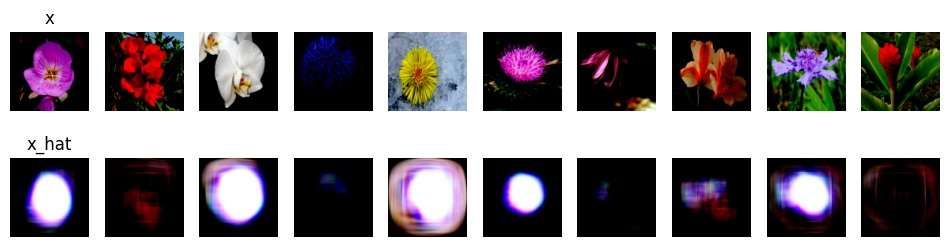

In [8]:
# autoencoder 학습 결과 확인 #

import matplotlib.pyplot as plt
import numpy as np

autoencoder.eval()
test_samples = torch.zeros((10, 3, 100, 100))
for i in range(10):
  test_samples[i] = test_dataset[100*i][0]
test_samples = test_samples.to(device)
z, test_output = autoencoder(test_samples)

fig, ax = plt.subplots(2, 10, figsize=(12,3))
ax[0][0].set_title('x')
ax[1][0].set_title('x_hat')
for i in range(10):
  ax[0][i].set_axis_off()
  ax[1][i].set_axis_off()
  ax[0][i].imshow(np.transpose(test_samples[i].detach().cpu().numpy(), (1,2,0)))
  ax[1][i].imshow(np.transpose(test_output[i].detach().cpu().numpy(), (1,2,0)))
plt.show()

In [10]:
##### Classifier 모델 코드 #####

class Classifier(nn.Module):
    def __init__(self, ):
        super(Classifier, self).__init__()
        self.classify = nn.Sequential(
                                      nn.Conv2d(16, 32, 3, 1, 0),
                                      nn.BatchNorm2d(32),
                                      nn.ReLU(),
                                      nn.MaxPool2d(2, 2),
                                      nn.Dropout2d(0.2),
                                      nn.Conv2d(32, 64, 3, 1, 0),
                                      nn.BatchNorm2d(64),
                                      nn.ReLU(),
                                      nn.MaxPool2d(2, 2),
                                      nn.Flatten(),
                                      nn.Dropout(0.5),
                                      nn.Linear(64*4*4, 512),
                                      nn.BatchNorm1d(512),
                                      nn.ReLU(),
                                      nn.Dropout(0.25),
                                      nn.Linear(512, 102),
        )
    def forward(self, input):
        return self.classify(input)

In [11]:
##### Classifier 학습 코드 #####

classifier = Classifier().to(device)
cls_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    [
        {"params": autoencoder.parameters(), "lr": 0.001},
        {"params": classifier.parameters(), "lr": 0.001},
    ]
)

autoencoder.train()
classifier.train()
total_batch_num = len(train_dataloader)
test_total_batch = len(test_dataloader)

epochs = 60
train_avg_costs = []
test_avg_costs = []

for epoch in range(epochs):
  autoencoder.train()
  classifier.train()
  avg_cost = 0

  for b_x, b_y in train_dataloader:
    b_x = b_x.to(device)
    b_y = b_y.to(device)
    z, b_x_hat = autoencoder(b_x)
    logits = classifier(z) # classification
    loss = cls_criterion(logits, b_y) # get cost

    avg_cost += loss / total_batch_num

    optimizer.zero_grad()
    loss.backward() # backward propagation
    optimizer.step() # update param
  
  train_avg_costs.append(avg_cost.detach())
  print('Epoch : {} / {}, cost : {}'.format(epoch+1, epochs, avg_cost))

  test_avg_cost = 0

  autoencoder.eval()
  classifier.eval()

  for b_x, b_y in test_dataloader:
    b_x = b_x.to(device)
    b_y = b_y.to(device)
    with torch.no_grad():
      z, b_x_hat = autoencoder(b_x)
      logits = classifier(z)
      test_loss = cls_criterion(logits, b_y)
    test_avg_cost += test_loss / test_total_batch

  test_avg_costs.append(test_avg_cost.detach())


Epoch : 1 / 60, cost : 4.7204790115356445
Epoch : 2 / 60, cost : 4.42809534072876
Epoch : 3 / 60, cost : 4.225956439971924
Epoch : 4 / 60, cost : 3.996609687805176
Epoch : 5 / 60, cost : 3.825728416442871
Epoch : 6 / 60, cost : 3.6551270484924316
Epoch : 7 / 60, cost : 3.52225399017334
Epoch : 8 / 60, cost : 3.403801441192627
Epoch : 9 / 60, cost : 3.2428359985351562
Epoch : 10 / 60, cost : 3.159557819366455
Epoch : 11 / 60, cost : 3.020432233810425
Epoch : 12 / 60, cost : 2.924499273300171
Epoch : 13 / 60, cost : 2.8317975997924805
Epoch : 14 / 60, cost : 2.7203989028930664
Epoch : 15 / 60, cost : 2.6404504776000977
Epoch : 16 / 60, cost : 2.540569543838501
Epoch : 17 / 60, cost : 2.433253526687622
Epoch : 18 / 60, cost : 2.339083433151245
Epoch : 19 / 60, cost : 2.2530059814453125
Epoch : 20 / 60, cost : 2.118286371231079
Epoch : 21 / 60, cost : 2.070197820663452
Epoch : 22 / 60, cost : 1.980514407157898
Epoch : 23 / 60, cost : 1.873751163482666
Epoch : 24 / 60, cost : 1.800552606582

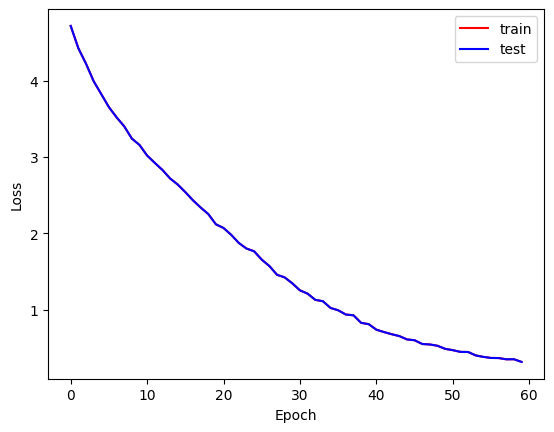

In [24]:
import matplotlib.pyplot as plt
import numpy as np

train_avg_costs_array = []
test_avg_costs_array = []
for tensor in train_avg_costs:
  train_avg_costs_array.append(tensor.cpu())
for tensor in train_avg_costs:
  test_avg_costs_array.append(tensor.cpu())
epoch = range(epochs)
plt.plot(epoch, train_avg_costs_array, 'r-')
plt.plot(epoch, test_avg_costs_array, 'b-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'test'])
plt.show()

In [17]:
##### Classifier 정확도 측정 코드 #####

correct = 0
total = 0

classifier.eval()
autoencoder.eval()

for b_x, b_y in test_dataloader:
  b_x = b_x.to(device)
  b_y = b_y.to(device)
  with torch.no_grad():
    z, b_x_hat = autoencoder(b_x)
    logits = classifier(z)
  
  predicts = torch.argmax(logits, dim=1)

  total += len(b_y)
  correct += (predicts == b_y).sum().item()

print(f'Accuracy of the netwark on test images: {100 * correct / total} %')

Accuracy of the netwark on test images: 23.288339567409334 %
